In [34]:
%matplotlib notebook
from collections import OrderedDict
from typing import Dict, Callable
from inspect import signature
import numpy.random as rd
import matplotlib.pyplot as plt
import json
import numpy as np

import qcodes as qc
from qcodes import Station
from qcodes.dataset.experiment_container import Experiment
from qcodes.tests.instrument_mocks import DummyInstrument
from qcodes.dataset.param_spec import ParamSpec

In [8]:
# This cell will eventually go into the core and thus become a single import

class Runner:
    """
    Context manager for the measurement. 
    Lives inside a Measurement and should never be instantiated
    outside a Measurement.
    """
    def __init__(self, enteractions: OrderedDict, exitactions: OrderedDict,
                 experiment: Experiment=None, station: Station=None) -> None:
        self.enteractions = enteractions
        self.exitactions = exitactions
        self.experiment = experiment
        self.station = station
        
    def __enter__(self) -> None:
        # first do whatever bootstrapping the user specified
        for func, args in self.enteractions.items():
            func(*args)
        
        # next set up the "datasaver"
        if self.experiment:
            eid = self.experiment.id
        else:
            eid = None
        
        self.ds = qc.new_data_set('name', eid)
        
        # .. and give it a snapshot as metadata
        if self.station is None:
            station = qc.Station.default
        else:
            station = self.station
            
        self.ds.add_metadata('snapshot', json.dumps(station.snapshot()))
        
        return self.ds
        

    def __exit__(self, exception_type, exception_value, traceback) -> None:
        # perform the "teardown" events
        for func, args in self.exitactions.items():
            func(*args)
            
        # and finally mark the dataset as closed, thus
        # finishing the measurement
        self.ds.mark_complete()
        
        print('-'*25)
        print('Finished dataset')
        print(self.ds)


class Measurement:
    """
    Measurement procedure container
    """
    def __init__(self, exp: Experiment=None, station=None) -> None:
        """
        Init
        
        Args:
            exp: Specify the experiment to use. If not given
                the default one is used
            station: The QCoDeS station to snapshot
        """
        # TODO: The sequence of actions probably matters A LOT
        self.exp = exp
        self.exitactions = OrderedDict()  # key: function, item: args
        self.enteractions = OrderedDict()  # key: function, item: args
        self.experiment = exp
        self.station = station
        
    def addBeforeRun(self, func: Callable, args: tuple) -> None:
        """
        Add an action to be performed before the measurement.
        
        Args:
            func: Function to be performed
            args: The arguments to said function
        """
        # some tentative cheap checking
        nargs = len(signature(func).parameters)
        if len(args) != nargs:
            raise ValueError('Mismatch between function call signature and '
                             'the provided arguments.')
        
        self.enteractions[func] = args
        
    def addAfterRun(self, func: Callable, args: tuple) -> None:
        """
        Add an action to be performed after the measurement.
        
        Args:
            func: Function to be performed
            args: The arguments to said function
        """
        # some tentative cheap checking
        nargs = len(signature(func).parameters)
        if len(args) != nargs:
            raise ValueError('Mismatch between function call signature and '
                             'the provided arguments.')
        
        self.exitactions[func] = args
        
    def run(self):
        """
        Returns the context manager for the experimental run
        """
        return Runner(self.enteractions, self.exitactions,
                      self.experiment)
    

In [9]:
dmm = DummyInstrument('dmm', gates=['v1', 'v2'])
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])

station = qc.Station(dmm, dac)

KeyError: 'Another instrument has the name: dmm'

In [29]:
dac.ch1.get = lambda : 3*rd.randn()

In [30]:
# now make some silly set-up and tear-down actions

def veryfirst():
    print('Starting the measurement')

def numbertwo(inst1, inst2):
    print('Doing stuff with the following two instruments: {}, {}'.format(inst1, inst2))
    
def thelast():
    print('End of experiment')

In [41]:
# And then run an experiment

meas = Measurement()
meas.addBeforeRun(veryfirst, ())
meas.addBeforeRun(numbertwo, (dmm, dac))
meas.addAfterRun(thelast, ())

with meas.run() as datasaver:
    
    # I guess we are free to add whatever metadata we feel like
    # to a ParamSpec e.g. unit, label
    datasaver.add_parameter(ParamSpec('set_v', 'number'))
    datasaver.add_parameter(ParamSpec('get_v', 'number'))
    
    datasaver.subscribe(notifier)
    
    for ii, set_v in enumerate(range(0, 250)):
        dmm.v1.set(set_v)
        get_v = dac.ch1.get()
        datasaver.add_result({'set_v': set_v, 'get_v': get_v})
        
        # some weird simulation of an adaptive sweep
        if get_v > 5:
            print(f'That was too much at step {ii+1}!')
            break

Starting the measurement
Doing stuff with the following two instruments: <DummyInstrument: dmm>, <DummyInstrument: dac>
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
It happened again
That was too much at step 75!
End of experiment
It happened again
It happened again
-------------------------
Finished dataset
name #34@./experiments.db
-------------------------
set_v - number
get_v - number


<IPython.core.display.Javascript object>


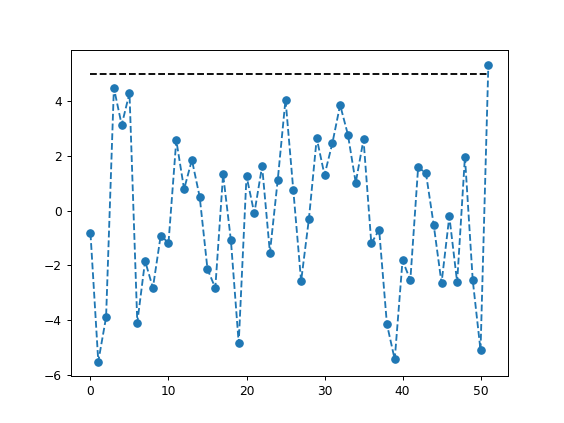

In [35]:
ds = qc.load_by_id(32)

xx = ds.get_data('set_v')
yy = ds.get_data('get_v')

fig, ax = plt.subplots()
ax.plot(xx, yy, '--o')
ax.plot(xx, np.ones_like(xx)*5, 'k--')


In [ ]:
[print(ds) for ds in baby_exp.data_sets()]

In [37]:
ds.get_metadata('snapshot')

'{"instruments": {"dmm": {"parameters": {"IDN": {"value": {"vendor": null, "model": "dmm", "serial": null, "firmware": null}, "ts": "2017-10-11 17:16:34", "__class__": "qcodes.instrument.parameter.StandardParameter", "vals": "<Anything>", "label": "IDN", "instrument": "qcodes.tests.instrument_mocks.DummyInstrument", "instrument_name": "dmm", "unit": "", "name": "IDN"}, "v1": {"value": 249, "ts": "2017-10-11 17:39:07", "__class__": "qcodes.instrument.parameter.ManualParameter", "vals": "<Numbers -800<=v<=400>", "label": "Gate v1", "instrument": "qcodes.tests.instrument_mocks.DummyInstrument", "instrument_name": "dmm", "unit": "V", "name": "v1"}, "v2": {"value": 0, "ts": "2017-10-11 17:16:34", "__class__": "qcodes.instrument.parameter.ManualParameter", "vals": "<Numbers -800<=v<=400>", "label": "Gate v2", "instrument": "qcodes.tests.instrument_mocks.DummyInstrument", "instrument_name": "dmm", "unit": "V", "name": "v2"}}, "functions": {}, "submodules": {}, "__class__": "qcodes.tests.instr

In [40]:
def notifier(*args):
    print('It happened again')